Results For Convnext Model with T = 10 and p=0.1 head only

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk


from pathlib import Path
import torch
import numpy as np
import pandas as pd
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load predictions and targets from pickle file

pickle_file = "/workspace/projects/uncertainbird/configs/experiment/Thesis/Convnext/MCD/predictions_convnext_dropout_p_0_1"
with open(pickle_file, "rb") as f:
    data = pickle.load(f)

predictions = data["predictions"]
targets = data["targets"]
metadata = data["metadata"]

print(f"Loaded data with {metadata['total_samples']} samples")
print(f"Predictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")
print(f"Model info: {metadata['model_info']}")
print(f"Save logits: {metadata['save_logits']}")

# Display some basic statistics
print(f"\nPrediction statistics:")
print(f"  Min: {predictions.min():.4f}")
print(f"  Max: {predictions.max():.4f}")
print(f"  Mean: {predictions.mean():.4f}")
print(f"  Std: {predictions.std():.4f}")

print(f"\nTarget statistics:")
print(f"  Min: {targets.min():.4f}")
print(f"  Max: {targets.max():.4f}")
print(f"  Mean: {targets.mean():.4f}")
print(f"  Sum: {targets.sum():.0f} (total positive labels)")
# Eingaben
pred = predictions
targ = targets

# Tensors -> float32
if isinstance(pred, torch.Tensor):
    pred = pred.detach().float().cpu()
if isinstance(targ, torch.Tensor):
    targ = targ.detach().float().cpu()

# Heuristik: Sind es schon Wahrscheinlichkeiten?
# (alles in [0,1] und kein Wert <0 oder >1)
already_probs = (pred.min() >= 0.0) and (pred.max() <= 1.0)

if already_probs:
    probs = pred
else:
    probs = torch.sigmoid(pred)

# Quick-Diagnose
print("pred min/max/mean BEFORE conversion:", float(pred.min()), float(pred.max()), float(pred.mean()))
print("probs min/max/mean AFTER conversion:", float(probs.min()), float(probs.max()), float(probs.mean()))

# Falls die Logits wirklich rund um 0 liegen:
# -> das Modell ist sehr unsicher; Histogramm checken hilft
# z.B.:
# import matplotlib.pyplot as plt
# plt.hist(pred.numpy().ravel(), bins=100); plt.show()

# In DataFrame gießen (wie raw_out.csv)
probs_np = probs.numpy()
targ_np  = targ.numpy()

if probs_np.ndim == 1:  probs_np = probs_np[:, None]
if targ_np.ndim  == 1:  targ_np  = targ_np[:, None]

n_classes = probs_np.shape[1]
pred_cols   = [f"prob_class_{i}" for i in range(n_classes)]
target_cols = [f"target_class_{i}" for i in range(n_classes)]

df = pd.DataFrame(np.hstack([probs_np, targ_np]), columns=pred_cols + target_cols)
print(df.head())
print("targets shape:", targets.shape)
print("targets dtype:", targets.dtype)
print("sum over all targets:", float(targets.sum()))
print("per-class sums (first 20):",
      [int(targets[:, i].sum()) for i in range(min(targets.shape[1], 20))])
print("metadata keys:", list(metadata.keys()))

Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 21])
Targets shape: torch.Size([12000, 21])
Model info: {'class_name': 'MCDropoutModule', 'task': 'multilabel', 'num_classes': None}
Save logits: True

Prediction statistics:
  Min: 0.0000
  Max: 0.9995
  Mean: 0.0023
  Std: 0.0328

Target statistics:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.0248
  Sum: 6254 (total positive labels)
pred min/max/mean BEFORE conversion: 0.0 0.99951171875 0.0022958400659263134
probs min/max/mean AFTER conversion: 0.0 0.99951171875 0.0022958400659263134
   prob_class_0  prob_class_1  prob_class_2  prob_class_3  prob_class_4  \
0      0.000021      0.000086      0.000026      0.000104      0.000122   
1      0.000048      0.000287      0.000002      0.000220      0.000619   
2      0.000003      0.865723      0.000358      0.000001      0.000051   
3      0.015717      0.000013      0.000074      0.000015      0.000045   
4      0.000045      0.000278      0.000039      0.000165      0.000265

In [33]:
# Optional imports (only used if available)
try:
    from sklearn.metrics import (
        roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
        confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score,
        brier_score_loss, log_loss
    )
    SKLEARN_AVAILABLE = True
except Exception as e:
    print("scikit-learn not available; some metrics/plots will be skipped.", e)
    SKLEARN_AVAILABLE = False

In [34]:
prob_cols = [c for c in df.columns if c.startswith("prob_class_")]
target_cols = [c for c in df.columns if c.startswith("target_class_")]
print("Num samples (N):", len(df))
print("Probability columns:", prob_cols)
print("Probs min/max:", float(df[prob_cols].min().min()), float(df[prob_cols].max().max()))
C = len(prob_cols)
print("Detected classes (C):", C)


Num samples (N): 12000
Probability columns: ['prob_class_0', 'prob_class_1', 'prob_class_2', 'prob_class_3', 'prob_class_4', 'prob_class_5', 'prob_class_6', 'prob_class_7', 'prob_class_8', 'prob_class_9', 'prob_class_10', 'prob_class_11', 'prob_class_12', 'prob_class_13', 'prob_class_14', 'prob_class_15', 'prob_class_16', 'prob_class_17', 'prob_class_18', 'prob_class_19', 'prob_class_20']
Probs min/max: 0.0 0.99951171875
Detected classes (C): 21


In [35]:
Y_true = df[target_cols].values.astype(int)  # [N, C] in {0,1}
Y_prob = df[prob_cols].values.astype(float)  # [N, C] in [0,1]
# Per-class AUROC & AUPRC
auroc_per_class = []
auprc_per_class = []
prevalence_per_class=[]
for j in range(Y_prob.shape[1]):
    try:
        auroc = roc_auc_score(Y_true[:, j], Y_prob[:, j])
        prevalence_class_i = df[f"target_class_{j}"].mean()
        
    except Exception:
        auroc = np.nan
    try:
        auprc = average_precision_score(Y_true[:, j], Y_prob[:, j])
    except Exception:
        auprc = np.nan
    auroc_per_class.append(auroc)
    auprc_per_class.append(auprc)
    prevalence_per_class.append(prevalence_class_i)
 


metrics_df = pd.DataFrame({
    "class": list(range(C)),
    "AUROC": auroc_per_class,
    "AUPRC": auprc_per_class,
    "baseline prevalence":prevalence_per_class,
})
display(metrics_df)

# Macro averages
print("Macro AUROC:", np.nanmean(auroc_per_class))
print("Macro AUPRC:", np.nanmean(auprc_per_class))

,class,AUROC,AUPRC,baseline prevalence
0,0,0.809371,0.510256,0.055917
1,1,0.878674,0.812478,0.223000
2,2,0.885656,0.625501,0.090167
3,3,0.955388,0.779476,0.001833
4,4,0.797589,0.451692,0.061250
5,5,0.772814,0.000366,0.000083
6,6,0.901010,0.426973,0.014583
7,7,0.654648,0.010363,0.002333
8,8,0.856401,0.586892,0.026667
9,9,0.935616,0.684022,0.002250


Macro AUROC: 0.8804048710029981
Macro AUPRC: 0.4628942990519992


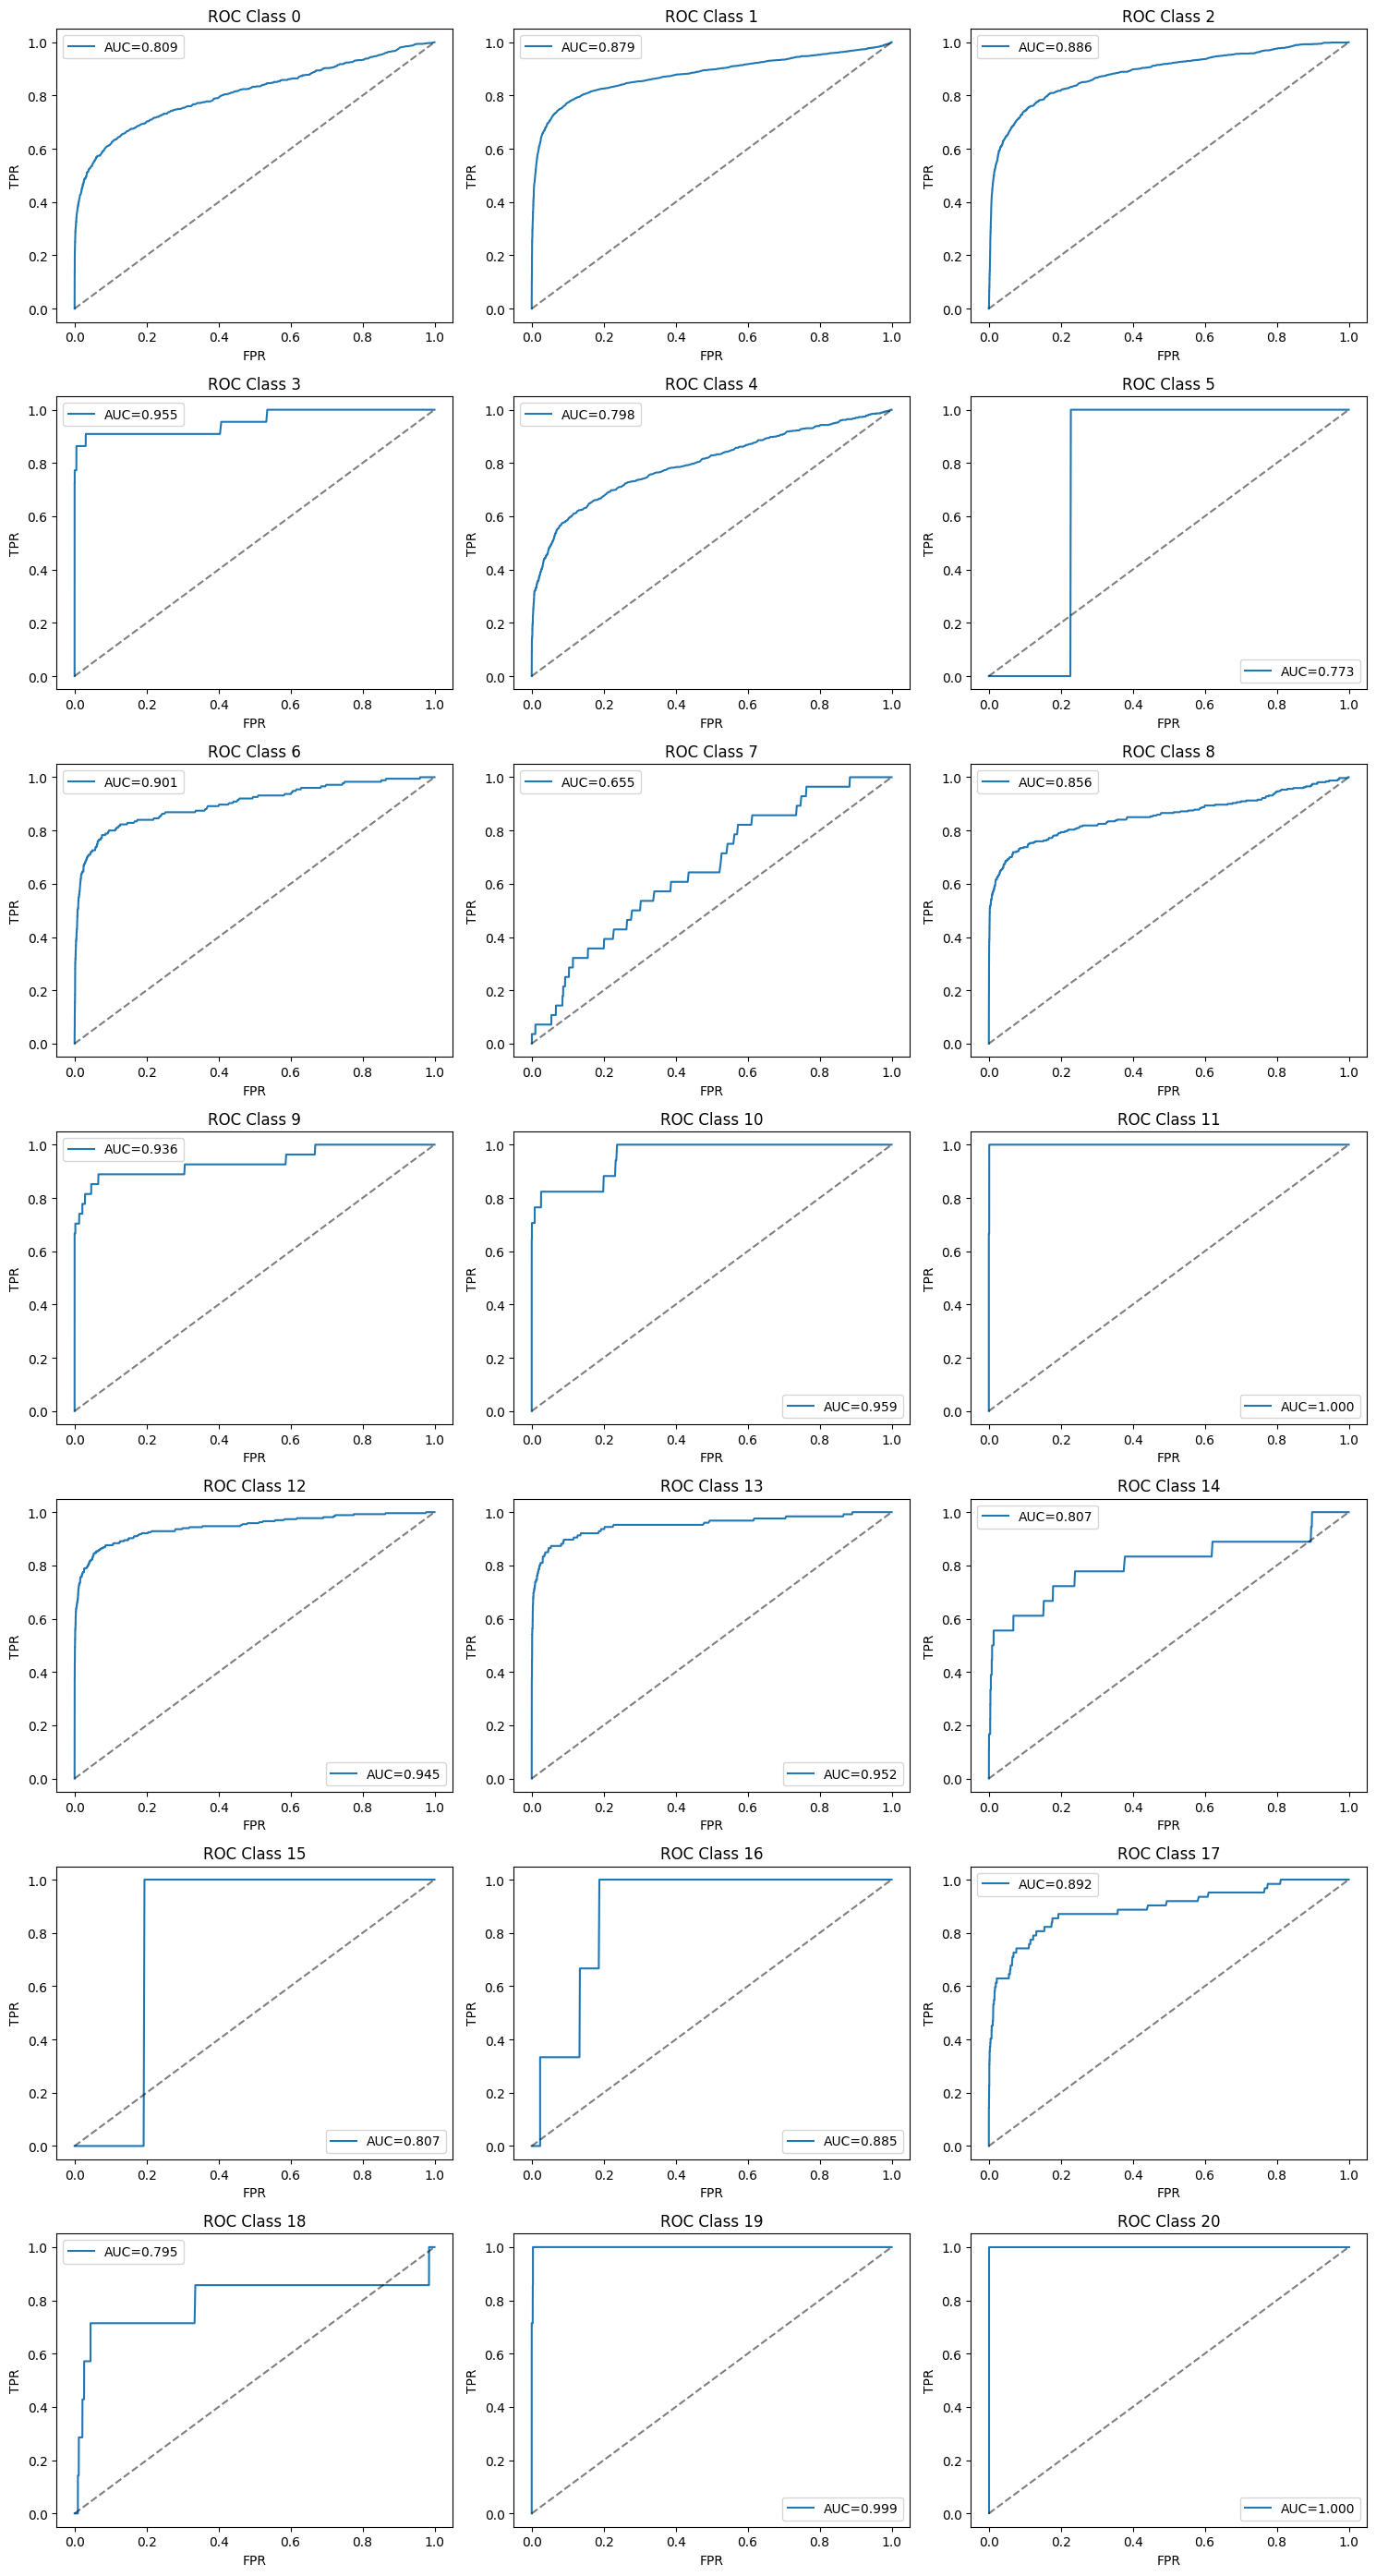

In [36]:
import math

n_classes = Y_prob.shape[1]
cols = 3                               # how many plots per row
rows = math.ceil(n_classes / cols)     # rows needed

# ---------------- ROC curves ----------------
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for j in range(n_classes):
    ax = axes[j]
    try:
        fpr, tpr, _ = roc_curve(Y_true[:, j], Y_prob[:, j])
        ax.plot(fpr, tpr, label=f"AUC={auroc_per_class[j]:.3f}")
        ax.plot([0, 1], [0, 1], "k--", alpha=0.5)
        ax.set_title(f"ROC Class {j}")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.legend()
    except Exception as e:
        ax.set_title(f"ROC Class {j} (error)")
        print(f"Skipping ROC for class {j}: {e}")

# Hide empty subplots (if n_classes not multiple of cols)
for k in range(n_classes, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()


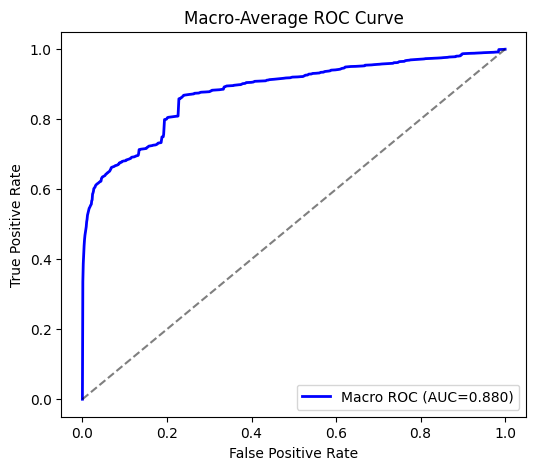

In [37]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# define common FPR grid
fpr_grid = np.linspace(0, 1, 1000)

tpr_list = []
auroc_per_class = []

for j in range(n_classes):
    try:
        fpr, tpr, _ = roc_curve(Y_true[:, j], Y_prob[:, j])
        auroc = auc(fpr, tpr)
        auroc_per_class.append(auroc)

        # interpolate TPR to common grid
        tpr_interp = np.interp(fpr_grid, fpr, tpr)
        tpr_interp[0] = 0.0
        tpr_list.append(tpr_interp)
    except Exception as e:
        print(f"Skipping class {j}: {e}")

# compute macro-average TPR and AUROC
tpr_macro = np.mean(tpr_list, axis=0)
macro_auroc = auc(fpr_grid, tpr_macro)

# plot macro ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr_grid, tpr_macro, label=f"Macro ROC (AUC={macro_auroc:.3f})", color="blue", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Average ROC Curve")
plt.legend(loc="lower right")
plt.show()

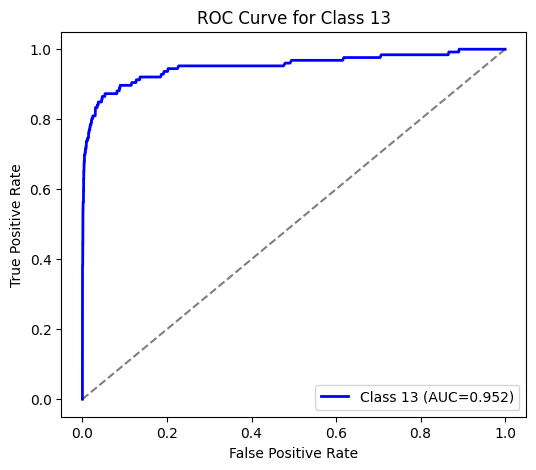

In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class_id = 13
  # choose the class you want

fpr, tpr, _ = roc_curve(Y_true[:, class_id], Y_prob[:, class_id])
auroc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Class {class_id} (AUC={auroc:.3f})", color="blue", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve for Class {class_id}")
plt.legend(loc="lower right")
plt.show()

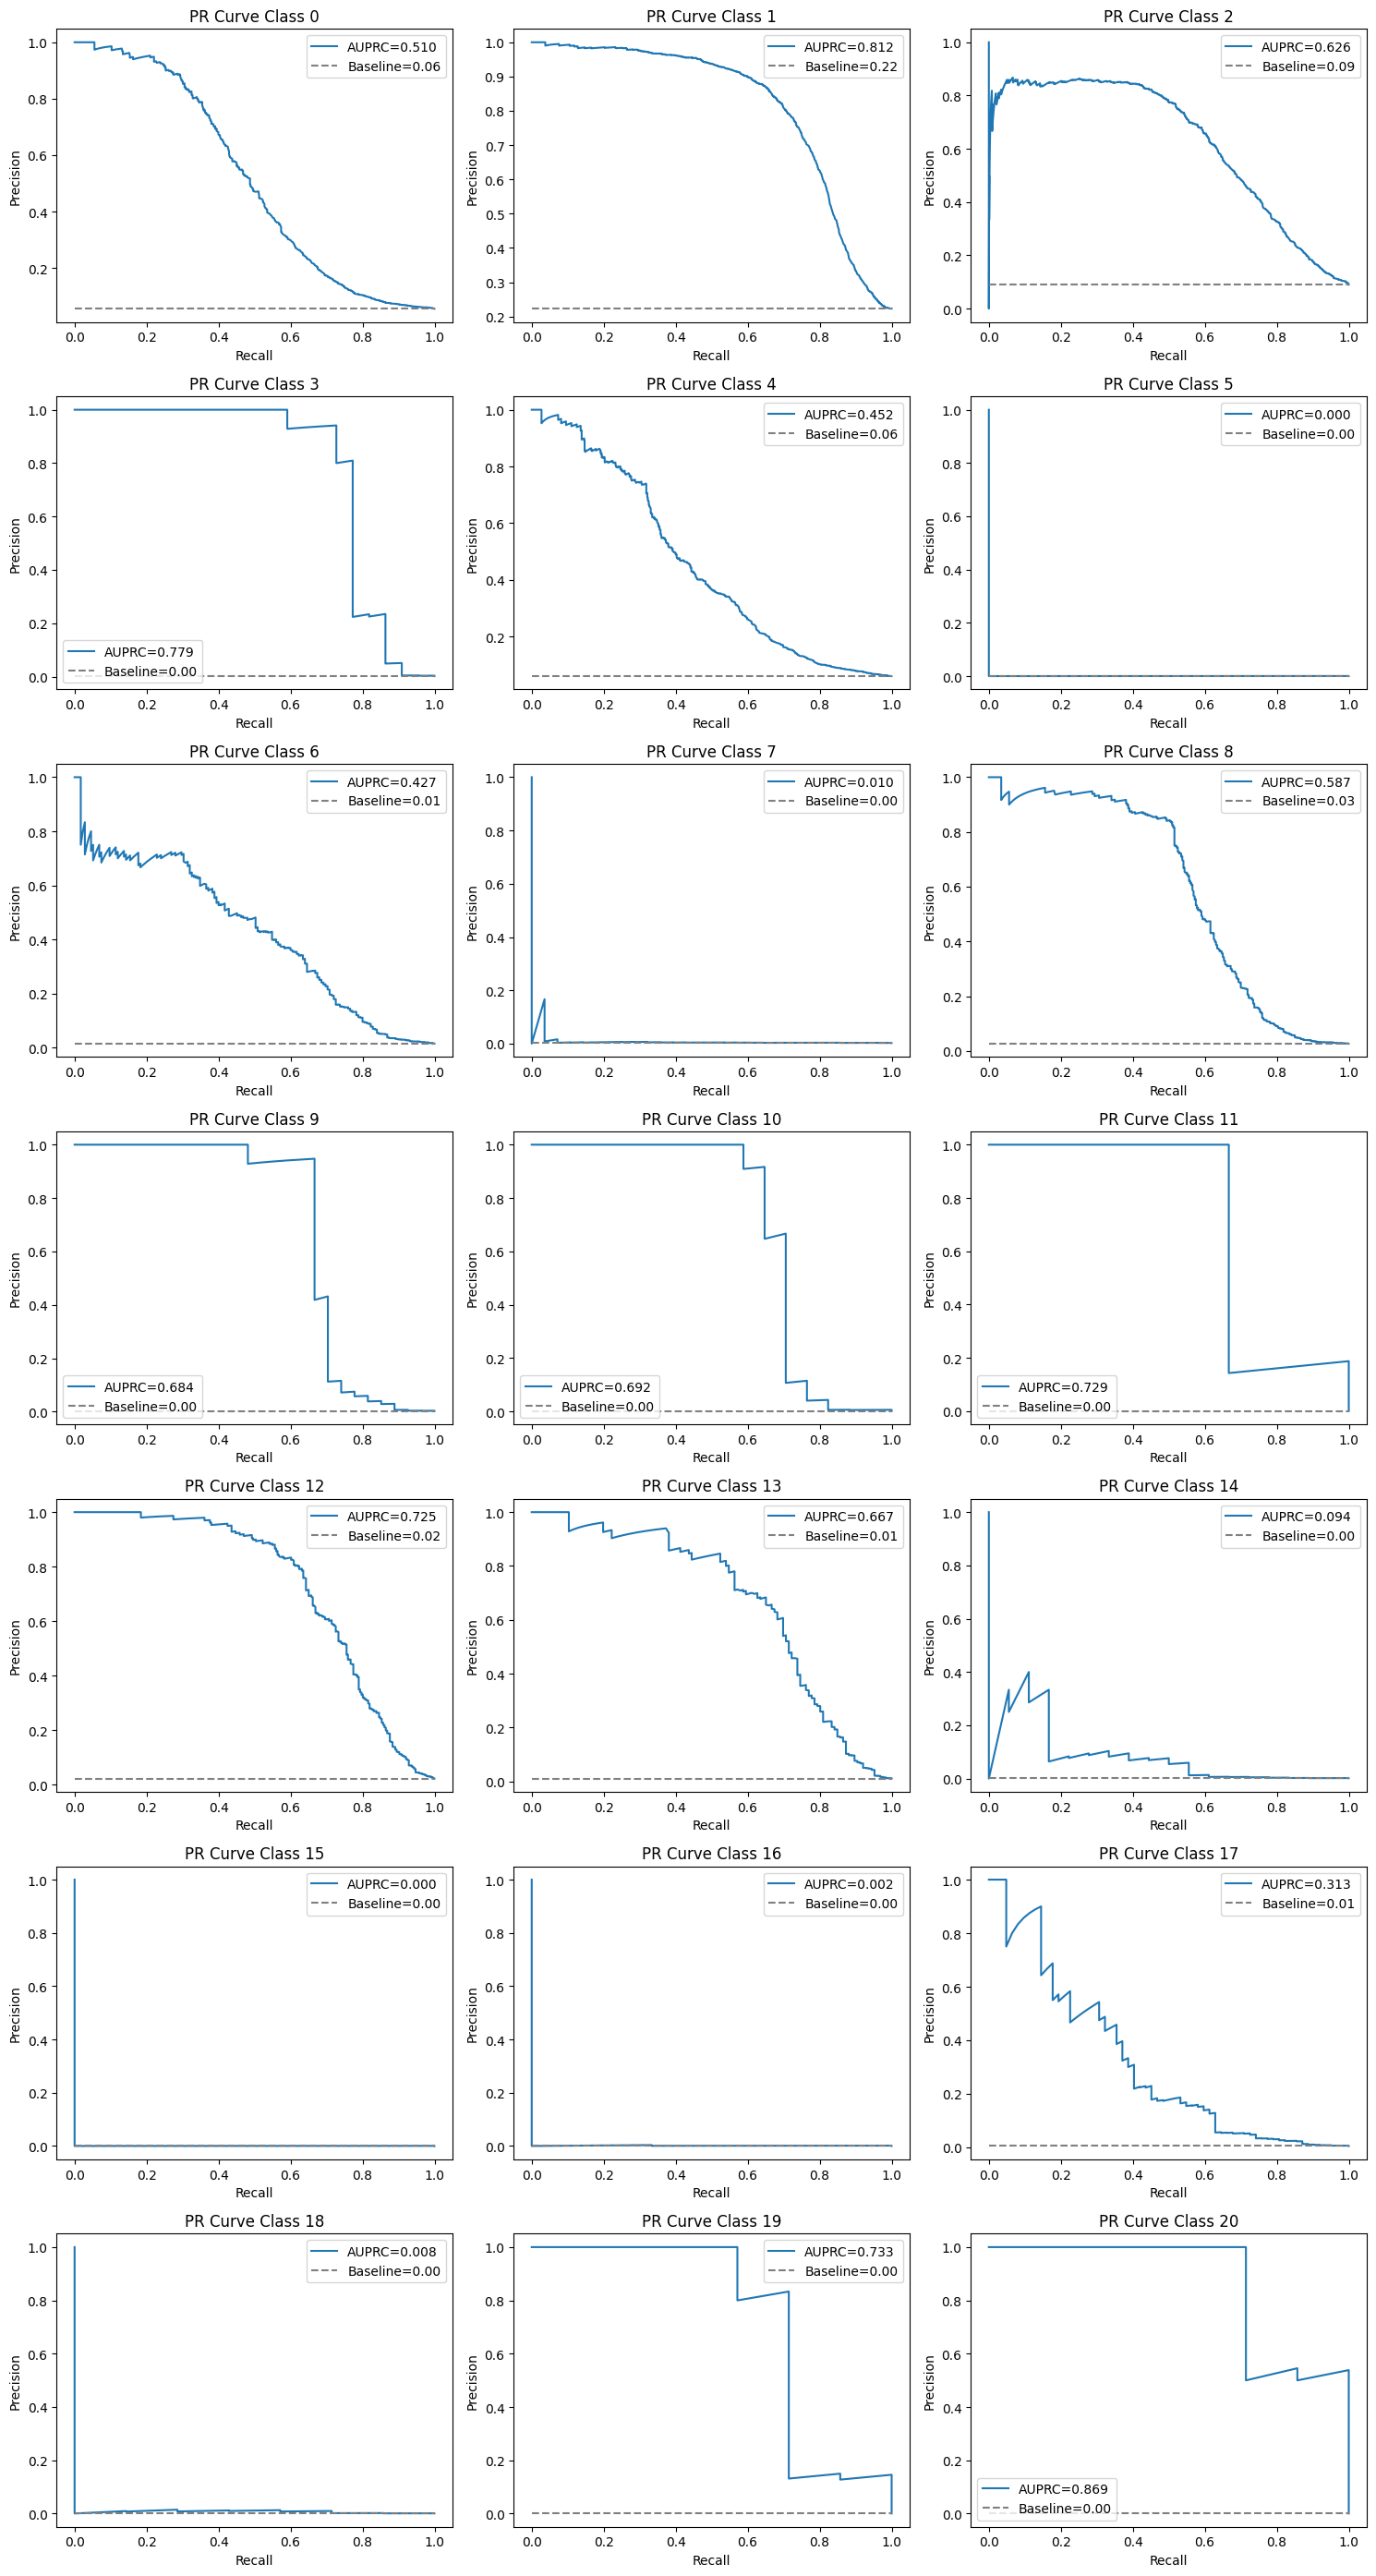

In [39]:
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for j in range(n_classes):
    ax = axes[j]
    try:
        precision, recall, _ = precision_recall_curve(Y_true[:, j], Y_prob[:, j])
        baseline = prevalence_per_class[j]
        ax.plot(recall, precision, label=f"AUPRC={auprc_per_class[j]:.3f}")
        ax.hlines(baseline, 0, 1, colors="gray", linestyles="--", label=f"Baseline={baseline:.2f}")
        ax.set_title(f"PR Curve Class {j}")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend()
    except Exception as e:
        ax.set_title(f"PR Class {j} (error)")
        print(f"Skipping PR for class {j}: {e}")

for k in range(n_classes, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

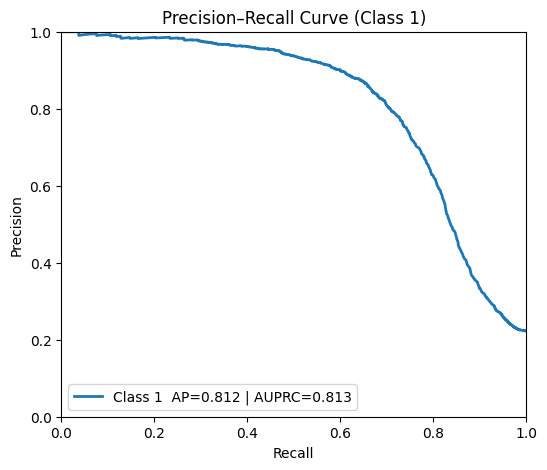

In [40]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
import matplotlib.pyplot as plt
import numpy as np

class_id = 1  # <-- pick the class you want

# PR points
precision, recall, _ = precision_recall_curve(Y_true[:, class_id], Y_prob[:, class_id])

# AUPRC (choose one; AP is most common)
ap = average_precision_score(Y_true[:, class_id], Y_prob[:, class_id])  # Average Precision
auprc = auc(recall, precision)  # Area under PR curve

# Baseline = prevalence of positives for that class
baseline = Y_true[:, class_id].mean()

plt.figure(figsize=(6,5))
plt.plot(recall, precision, linewidth=2, label=f"Class {class_id}  AP={ap:.3f} | AUPRC={auprc:.3f}")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (Class {class_id})")
plt.legend(loc="lower left")
plt.show()


{'ECE': 0.02252162032113189, 'MCE': 0.6924115895318441}


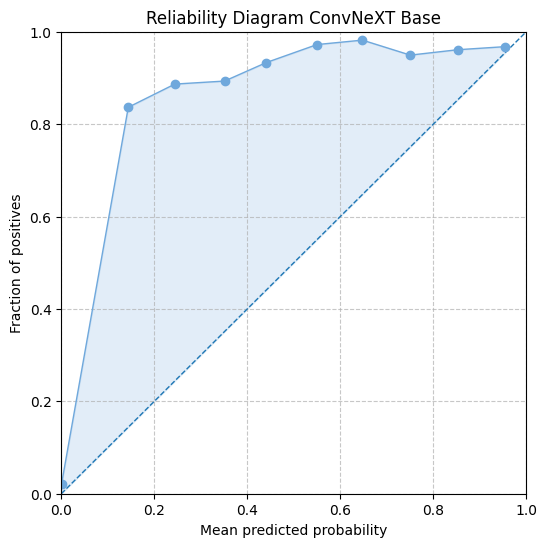

{'ECE@k': 0.08678273564742671, 'MCE@k': 0.6924115895318441}


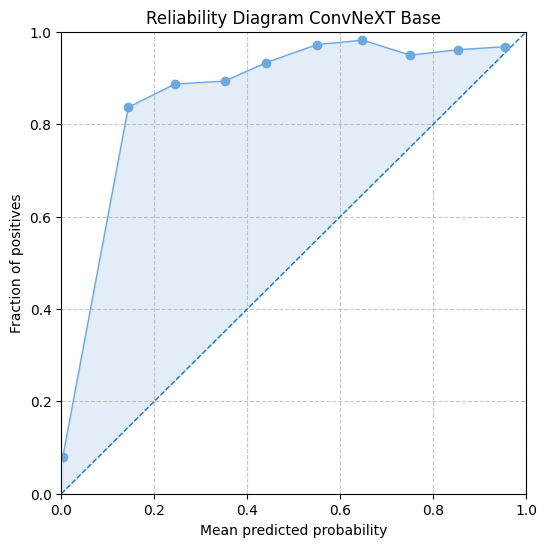

Brier: 0.022361011098469715


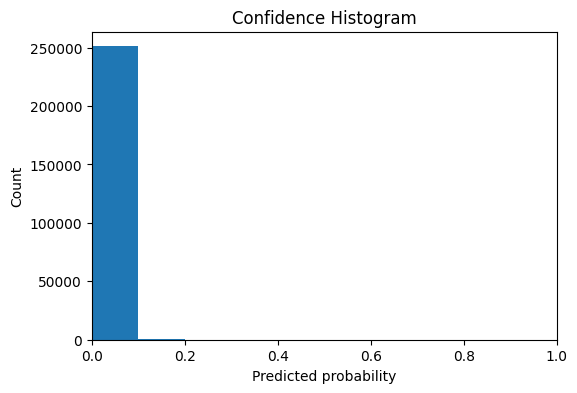

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==============================
# Extraktion aus DataFrame
# ==============================
def extract_probs_targets(df, prob_prefix="prob_class_", target_prefix="target_class_"):
    prob_cols = [c for c in df.columns if c.startswith(prob_prefix)]
    targ_cols = [c for c in df.columns if c.startswith(target_prefix)]
    if len(prob_cols) == 0 or len(targ_cols) == 0:
        raise ValueError("Keine passenden Spalten gefunden")

    def _suffix_idx(name, prefix): return int(name.replace(prefix, ""))
    prob_cols_sorted = sorted(prob_cols, key=lambda c: _suffix_idx(c, prob_prefix))
    targ_cols_sorted = sorted(targ_cols, key=lambda c: _suffix_idx(c, target_prefix))

    prob_ids = [_suffix_idx(c, prob_prefix) for c in prob_cols_sorted]
    targ_ids = [_suffix_idx(c, target_prefix) for c in targ_cols_sorted]
    if prob_ids != targ_ids:
        raise ValueError("Mismatch zwischen Prob- und Target-Spalten")

    y_prob = df[prob_cols_sorted].to_numpy(dtype=float)
    y_true = df[targ_cols_sorted].to_numpy(dtype=float)
    y_true = (y_true > 0.5).astype(int)
    y_prob = np.clip(y_prob, 0.0, 1.0)
    return y_prob, y_true

# ==============================
# Helfer für Reliability
# ==============================
def _bin_stats(conf, labels, n_bins=10, quantile=False):
    conf = np.asarray(conf).reshape(-1)
    labels = np.asarray(labels).reshape(-1)
    n = conf.size
    if quantile:
        qs = np.linspace(0, 1, n_bins + 1)
        try:
            edges = np.quantile(conf, qs, method="linear")
        except TypeError:
            edges = np.quantile(conf, qs)
        edges[0], edges[-1] = 0.0, 1.0
        edges = np.maximum.accumulate(edges)
    else:
        edges = np.linspace(0, 1, n_bins + 1)

    bin_confs, bin_accs, bin_weights, bin_gaps = [], [], [], []
    for b in range(n_bins):
        left, right = edges[b], edges[b+1]
        if b < n_bins - 1:
            m = (conf >= left) & (conf < right)
        else:
            m = (conf >= left) & (conf <= right)
        if np.any(m):
            c_mean = conf[m].mean()
            a_mean = labels[m].mean()
            w = m.sum() / n
            gap = abs(a_mean - c_mean)
        else:
            c_mean = (left + right) / 2
            a_mean, w, gap = np.nan, 0.0, 0.0
        bin_confs.append(c_mean); bin_accs.append(a_mean)
        bin_weights.append(w); bin_gaps.append(gap)

    bin_confs, bin_accs, bin_weights, bin_gaps = map(np.array, [bin_confs, bin_accs, bin_weights, bin_gaps])
    valid = bin_weights > 0
    ece = float(np.sum(bin_weights[valid] * bin_gaps[valid])) if np.any(valid) else 0.0
    mce = float(np.max(bin_gaps[valid])) if np.any(valid) else 0.0
    return bin_confs, bin_accs, bin_weights, ece, mce

def brier_score(y_true, y_prob):
    return float(np.mean((y_prob - y_true) ** 2))

# ==============================
# Plot Funktionen
# ==============================
def _plot_reliability(bin_confs, bin_accs, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    ax.plot([0,1],[0,1],"--",linewidth=1)
    mask = ~np.isnan(bin_accs)
    ax.plot(bin_confs[mask], bin_accs[mask], marker="o", linewidth=1, color="#6FA8DC")
    ax.fill_between(
        bin_confs[mask],
        bin_accs[mask],
        bin_confs[mask],   # diagonal reference
        color="#6FA8DC",
        alpha=0.2
    )
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    plt.grid(True, linestyle="--", alpha=0.7)
    ax.set_title(title)
    return ax

def plot_reliability_diagram_all(y_true, y_prob,title, n_bins=10, quantile=False, ax=None):
    conf, labels = y_prob.reshape(-1), y_true.reshape(-1)
    bin_confs, bin_accs, bin_weights, ece, mce = _bin_stats(conf, labels, n_bins, quantile)
    title = title
    _plot_reliability(bin_confs, bin_accs, title, ax=ax)
    return {"ECE": ece, "MCE": mce}

def plot_topk_reliability_diagram(y_true, y_prob,title, k=5, n_bins=10, quantile=False, ax=None):
    N,T = y_true.shape; k = min(k,T)
    idx = np.argpartition(-y_prob, kth=k-1, axis=1)[:, :k]
    rows = np.arange(N)[:,None]
    conf_topk = y_prob[rows, idx].reshape(-1)
    labels_topk = y_true[rows, idx].reshape(-1)
    bin_confs, bin_accs, bin_weights, ece, mce = _bin_stats(conf_topk, labels_topk, n_bins, quantile)
    title = title
    _plot_reliability(bin_confs, bin_accs, title, ax=ax)
    return {"ECE@k": ece, "MCE@k": mce}

def plot_confidence_histogram(conf, n_bins=10, ax=None):
    conf = np.asarray(conf).reshape(-1)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(conf, bins=n_bins, range=(0,1))
    ax.set_xlim(0,1)
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Count")
    ax.set_title("Confidence Histogram")
    return ax

# ==============================
#Wrapper für DataFrame
# ==============================
def plot_reliability_from_df(df, title, prob_prefix="prob_class_", target_prefix="target_class_", n_bins=10, quantile=False, ax=None):
    y_prob, y_true = extract_probs_targets(df, prob_prefix, target_prefix)
    return plot_reliability_diagram_all(y_true, y_prob, n_bins=n_bins, quantile=quantile, ax=ax, title = title)

def plot_topk_reliability_from_df(df, title, k=5, prob_prefix="prob_class_", target_prefix="target_class_", n_bins=10, quantile=False, ax=None):
    y_prob, y_true = extract_probs_targets(df, prob_prefix, target_prefix)
    return plot_topk_reliability_diagram(y_true, y_prob, k=k, n_bins=n_bins, quantile=quantile, ax=ax, title=title)

def brier_from_df(df, prob_prefix="prob_class_", target_prefix="target_class_"):
    y_prob, y_true = extract_probs_targets(df, prob_prefix, target_prefix)
    return brier_score(y_true, y_prob)



title="Reliability Diagram ConvNeXT MC Dropout"

# Klassisches Reliability Diagram
print(plot_reliability_from_df(df, n_bins=10, quantile=False, title=title))
plt.show()

# Top-k Reliability Diagram 
print(plot_topk_reliability_from_df(df, k=3, n_bins=10, quantile=False, title=title))
plt.show()

# Brier Score
print("Brier:", brier_from_df(df))

# Histogramm über alle Wahrscheinlichkeiten
probs = df[[c for c in df.columns if c.startswith("prob_class_")]].to_numpy().ravel()
plot_confidence_histogram(probs, n_bins=10)
plt.show()
